#**研究提案：基于特征工程和线性回归的Uber供需预测与运力优化**

###作者：Ashley Liang

###**阅读须知**


<p>
1.本项目仅用于个人研究与分析用途。
<p>
2.本项目所用数据集源自Kaggle：https://www.kaggle.com/datasets/yannisp/uber-pickups-enriched
<p>
3.数据包括：
2015 年 1 月 1 日至 2015 年 6 月 30 日期间纽约市 Uber 接载数据 (uber-raw-data-janjune-15.csv)。（数据来源：FiveThirtyEight，kaggle.com）
来自国家环境信息中心的天气数据。
LocationID 到行政区的映射。（由FiveThirtyEight提供）
纽约市公众假期。
<p>
4.主数据集包含 4 个变量的超过 1000 万条观测值，这些观测值按小时和按行政区进行汇总，然后与其余数据集合并，生成 13 个变量的 29,101 条观测值。这些观测值包括：
pickup_dt：观察的时间段。

行政区：纽约市的行政区。

取货次数：该期间的取货次数。

spd：风速（英里/小时）。

vsb：能见度（以英里为单位，精确到十分位）。

temp：华氏温度。

dewp：露点（华氏度）。

slp：海平面气压。

pcp01：1小时液体沉淀。

pcp06：6小时液体沉淀。

pcp24：24小时液体沉淀。

sd：积雪深度（英寸）。

hday：是假日 (Y) 还是不是假日 (N)。

###**研究问题与目标**

共享出行平台面临着供给减少和需求增加的矛盾，定价策略是平衡这一矛盾的关键。然而我们也可能忽略了其他影响供求平衡的因素如时间特征、天气特征。

**1.研究问题：**
如何仅用基础Excel操作完成特征工程，并利用Python(Google Colab)构建线性回归模型预测Uber出行的区域订单量？

**2.核心目标：**

  1.提取时间特征（小时、星期、节假日等）和基础天气数据，构建Uber订单量的线性预测模型，辅助决策；

  2.验证 “时间 - 天气” 特征对订单波动的解释力（R²>0.5）；

  3.识别高峰时段关键影响因素（如早高峰小时、暴雨天气）的量化影响。


###**文献综述**


Bibaswan Basu, M.P. Sebastian等(2024)指出影响共享平台用户体验的因素，其中就包括Monetary Resource(即价格)，时间资源，信息保护感知，应用程序可控性，这些因素影响到服务质量。刘征驰，蒋贵艳等(2021)指出，平台对于共享车和对乘客收取的交易费收到服务质量和出行需求强度的影响。危小超等(2024)等发现在“双平台”联合定价策略下，司机服务质量、司机忠诚度及乘客价格敏感度都将影响平台定价行为。这些研究过度聚焦于定价策略，尽管Shan Liu等(2021)量化了天气对网约车乘客量的影响，然而并没有考虑到时间特征，且类似研究较少。本文的创新点在于维度创新：从“定价中心”转向“非价格因素驱动”，将时间特征（如早、晚高峰）与天气数据等整合到Uber订单预测中，填补现有研究的空白。


###**导入库**

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

###**加载数据**


In [35]:
data = pd.read_csv('/content/uber_nyc_enriched.csv')  #注意该csv文件已经在excel中完成初步的特征工程

In [7]:
data.head()

,pickup_dt,borough,borough_num,pickups,spd,vsb,f_temp,f_dewp,slp,pcp01,...,sd,is_hday,hour,day_of_week,is_weekend,time_of_day,time_pf_day_code,weather,weather_code,precip
0,2015/1/1 1:00,Bronx,1,152,5.0,10.0,30.0,7.0,1023.5,0.0,...,0.0,1,1,4,0,off_peak,0,freezing,0,0.0
1,2015/1/1 1:00,Brooklyn,2,1519,5.0,10.0,30.0,7.0,1023.5,0.0,...,0.0,1,1,4,0,off_peak,0,freezing,0,0.0
2,2015/1/1 1:00,EWR,3,0,5.0,10.0,30.0,7.0,1023.5,0.0,...,0.0,1,1,4,0,off_peak,0,freezing,0,0.0
3,2015/1/1 1:00,Manhattan,4,5258,5.0,10.0,30.0,7.0,1023.5,0.0,...,0.0,1,1,4,0,off_peak,0,freezing,0,0.0
4,2015/1/1 1:00,Queens,5,405,5.0,10.0,30.0,7.0,1023.5,0.0,...,0.0,1,1,4,0,off_peak,0,freezing,0,0.0


In [ ]:
data.columns

Index(['pickup_dt', 'borough', 'borough_num', 'pickups', 'spd', 'vsb',
       'f_temp', 'f_dewp', 'slp', 'pcp01', 'pcp06', 'pcp24', 'sd', 'is_hday',
       'hour', 'day_of_week', 'is_weekend', 'time_of_day', 'time_pf_day_code',
       'weather', 'weather_code', 'precip'],
      dtype='object')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26058 entries, 0 to 26057
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pickup_dt         26058 non-null  object 
 1   borough           26058 non-null  object 
 2   borough_num       26058 non-null  int64  
 3   pickups           26058 non-null  int64  
 4   spd               26058 non-null  float64
 5   vsb               26058 non-null  float64
 6   f_temp            26058 non-null  float64
 7   f_dewp            26058 non-null  float64
 8   slp               26058 non-null  float64
 9   pcp01             26058 non-null  float64
 10  pcp06             26058 non-null  float64
 11  pcp24             26058 non-null  float64
 12  sd                26058 non-null  float64
 13  is_hday           26058 non-null  int64  
 14  hour              26058 non-null  int64  
 15  day_of_week       26058 non-null  int64  
 16  is_weekend        26058 non-null  int64 

###**特征工程&模型构建**

In [36]:
####feature Engineering With Excel and Python #请注意数据集已先于Excel中作了相应处理

In [8]:
# 1. 生成哑变量（独热编码），drop_first=True避免虚拟变量陷阱
hour_dummies = pd.get_dummies(data['hour'], prefix='hour', drop_first=True)  # 23个特征（排除hour=0）
day_dummies = pd.get_dummies(data['day_of_week'], prefix='day', drop_first=True)  # 6个特征（排除day=0）
borough_dummies = pd.get_dummies(data['borough'], prefix='borough', drop_first=True)  # 如5个区→4个特征
time_of_day_dummies = pd.get_dummies(data['time_of_day'], prefix='time_of_day', drop_first=True)  # 如3类→2个特征
weather_dummies = pd.get_dummies(data['weather'], prefix='weather', drop_first=True)  # 如5类→4个特征

# 2. 保留数值型天气/时间特征（如温度、风速、节假日）
numeric_features = [
    'spd', 'vsb', 'f_temp', 'f_dewp', 'slp',  # 天气数值指标
    'pcp01', 'pcp06', 'pcp24', 'sd', 'precip',
    'is_hday'  # 是否节假日（0/1，已数值化）
]
X_numeric = data[numeric_features]

# 3. 合并所有特征
X = pd.concat([
    X_numeric,
    hour_dummies,
    day_dummies,
    borough_dummies,
    time_of_day_dummies,
    weather_dummies
], axis=1)

# 目标变量：订单量
y = data['pickups']

####train and test

In [9]:

# 拆分数据（80%训练，20%测试）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42  # 固定随机种子保证可复现
)

# 训练模型
model = LinearRegression()
model.fit(X_train, y_train)

# 预测
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [10]:
# 计算指标
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"训练集R²: {r2_train:.3f}，测试集R²: {r2_test:.3f}")
print(f"训练集MSE: {mse_train:.1f}，测试集MSE: {mse_test:.1f}")

训练集R²: 0.722，测试集R²: 0.725
训练集MSE: 296807.6，测试集MSE: 303223.6


In [11]:
# 整理系数：特征名→系数值
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_
}).sort_values(by='coefficient', ascending=False)

# 查看正影响最大的10个特征（如早高峰、暴雨可能在此）
print("=== 正影响Top10 ===")
print(coef_df.head(10))

# 查看负影响最大的10个特征
print("\n=== 负影响Top10 ===")
print(coef_df.tail(10))

=== 正影响Top10 ===
              feature  coefficient
42  borough_Manhattan  2319.037506
40   borough_Brooklyn   479.929028
43     borough_Queens   256.282982
32            hour_22   213.859442
5               pcp01   207.560954
31            hour_21   198.044401
38              day_6   179.650528
29            hour_19   160.703429
9              precip   158.529666
33            hour_23   154.682662

=== 负影响Top10 ===
                     feature  coefficient
23                   hour_13  -152.577683
21                   hour_11  -166.484317
11                    hour_1  -179.483889
7                      pcp24  -197.872748
16                    hour_6  -267.029081
45  time_of_day_morning_peak  -285.568226
12                    hour_2  -355.833075
13                    hour_3  -423.511718
15                    hour_5  -480.775423
14                    hour_4  -491.622653


In [12]:
  # 1. 提取模型参数
intercept = model.intercept_  # 截距 β0
coefficients = model.coef_    # 特征系数 [β1, β2, ..., βn]
feature_names = X.columns     # 特征名称（与系数顺序一一对应）

# 2. 构建线性回归方程字符串
equation_parts = [f"{intercept:.2f}"]  # 先添加截距项
for feat, coef in zip(feature_names, coefficients):
    equation_parts.append(f"{coef:.2f}×{feat}")  # 格式：系数×特征名

linear_equation = "pickups = " + " + ".join(equation_parts)

# 3. 打印
print("=== 完整线性回归方程 ===")
print(linear_equation)



=== 完整线性回归方程 ===
pickups = 108.53 + 0.93×spd + 2.14×vsb + 0.86×f_temp + 2.24×f_dewp + -0.11×slp + 207.56×pcp01 + 7.78×pcp06 + -197.87×pcp24 + 2.67×sd + 158.53×precip + -15.79×is_hday + -179.48×hour_1 + -355.83×hour_2 + -423.51×hour_3 + -491.62×hour_4 + -480.78×hour_5 + -267.03×hour_6 + -142.13×hour_7 + 27.69×hour_8 + 95.90×hour_9 + -125.48×hour_10 + -166.48×hour_11 + -140.45×hour_12 + -152.58×hour_13 + -132.76×hour_14 + -79.09×hour_15 + -16.47×hour_16 + -8.18×hour_17 + 107.10×hour_18 + 160.70×hour_19 + 138.24×hour_20 + 198.04×hour_21 + 213.86×hour_22 + 154.68×hour_23 + 35.59×day_2 + 78.49×day_3 + 136.74×day_4 + 152.21×day_5 + 179.65×day_6 + 78.71×day_7 + 479.93×borough_Brooklyn + -49.21×borough_EWR + 2319.04×borough_Manhattan + 256.28×borough_Queens + -52.24×borough_Staten Island + -285.57×time_of_day_morning_peak + -112.29×time_of_day_off_peak + 70.61×weather_freezing + 21.21×weather_hot + 34.26×weather_mild


###**可视化**

####小时订单量（折线图）

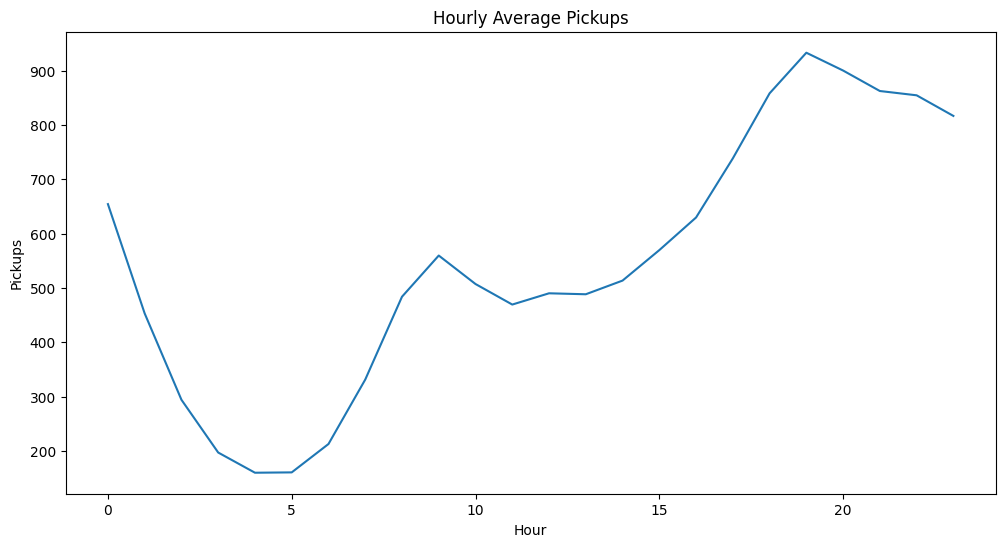

In [15]:
# Hourly Average Pickups 小时订单量折线图
plt.figure(figsize=(12,6))
data.groupby('hour')['pickups'].mean().plot(kind='line')
plt.title('Hourly Average Pickups')
plt.xlabel('Hour')
plt.ylabel('Pickups')
plt.show()

####星期几的订单量分布（箱线图）

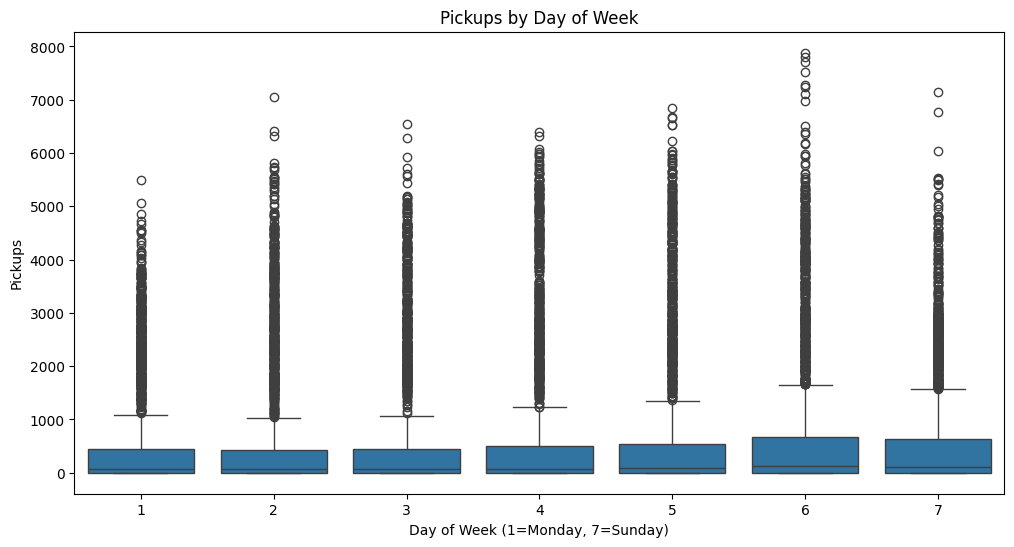

In [17]:
import seaborn as sns

# 星期几的订单量箱线图（假设day_of_week为1-7，对应周一到周日）
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='pickups', data=data)
plt.title('Pickups by Day of Week')
plt.xlabel('Day of Week (1=Monday, 7=Sunday)')
plt.ylabel('Pickups')
plt.show()

####天气类型与订单量（柱状图）

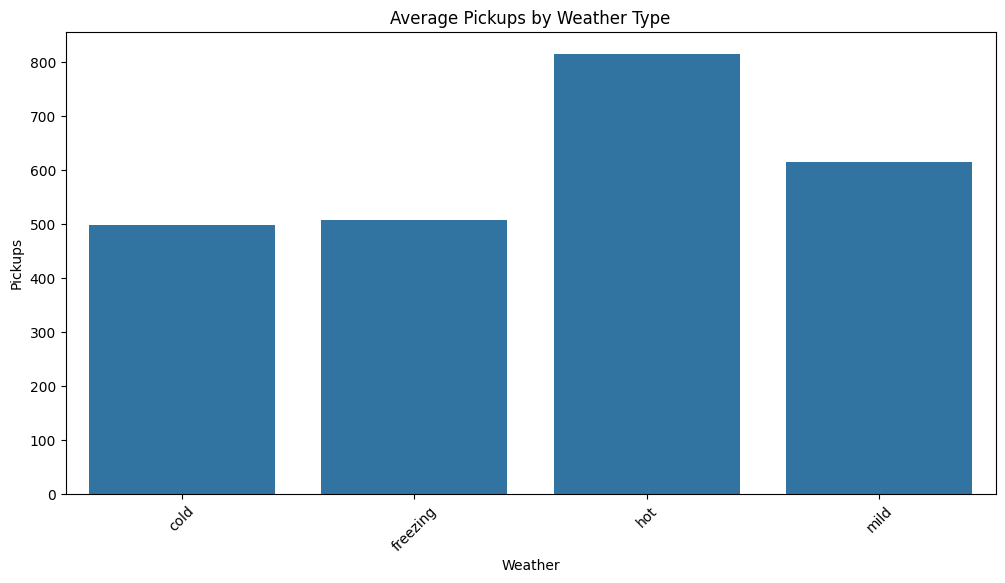

In [18]:
# 天气类型对订单量的平均影响（假设weather为分类变量）
weather_avg = data.groupby('weather')['pickups'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='weather', y='pickups', data=weather_avg)
plt.title('Average Pickups by Weather Type')
plt.xlabel('Weather')
plt.ylabel('Pickups')
plt.xticks(rotation=45)  # 旋转标签避免重叠
plt.show()

####各行政区平均订单量

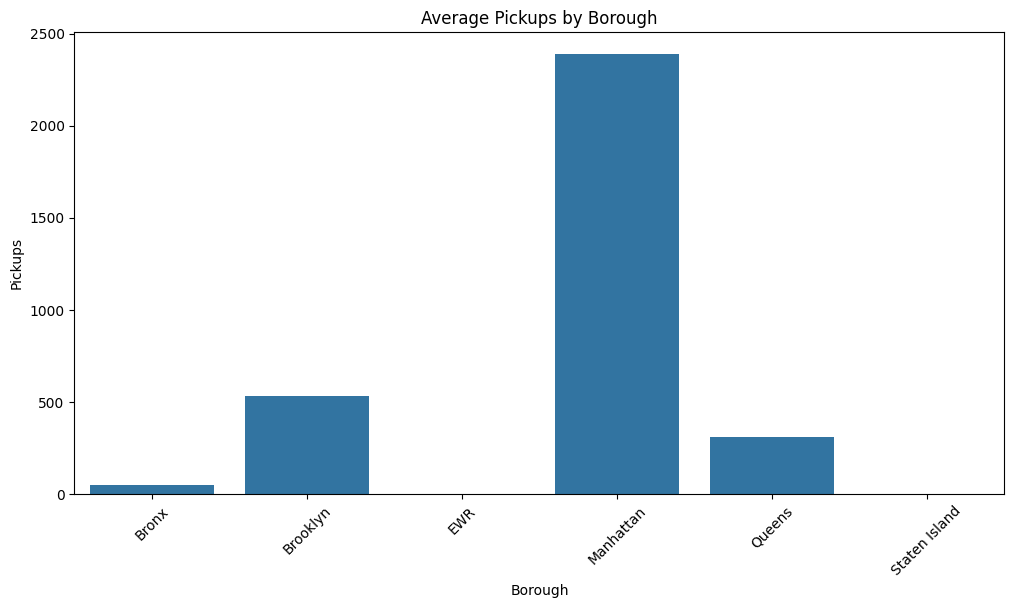

In [20]:
borough_avg = data.groupby('borough')['pickups'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='borough', y='pickups', data=borough_avg)
plt.title('Average Pickups by Borough')
plt.xlabel('Borough')
plt.ylabel('Pickups')
plt.xticks(rotation=45)
plt.show()

####节假日的平均订单量(柱状图）

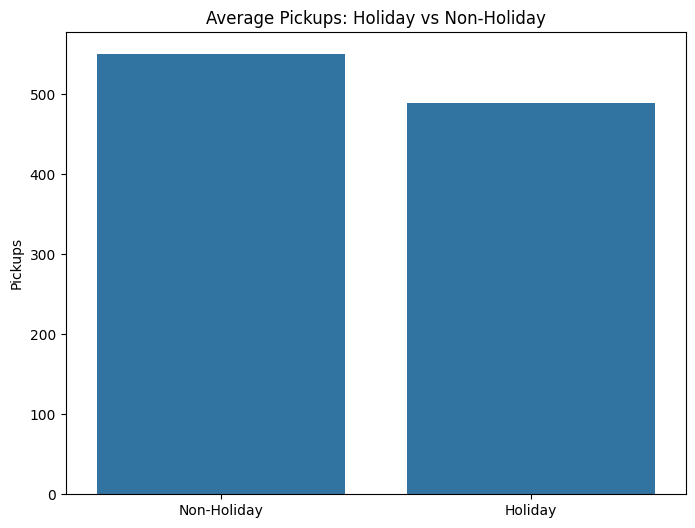

In [21]:
# 节假日（is_hday=1）与非节假日（is_hday=0）的平均订单量
hday_avg = data.groupby('is_hday')['pickups'].mean().reset_index()
hday_avg['is_hday'] = hday_avg['is_hday'].map({0: 'Non-Holiday', 1: 'Holiday'})

plt.figure(figsize=(8, 6))
sns.barplot(x='is_hday', y='pickups', data=hday_avg)
plt.title('Average Pickups: Holiday vs Non-Holiday')
plt.xlabel('')
plt.ylabel('Pickups')
plt.show()

####前20个重要影响的特征（系数绝对值）

<ipython-input-29-b7b01549e119>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


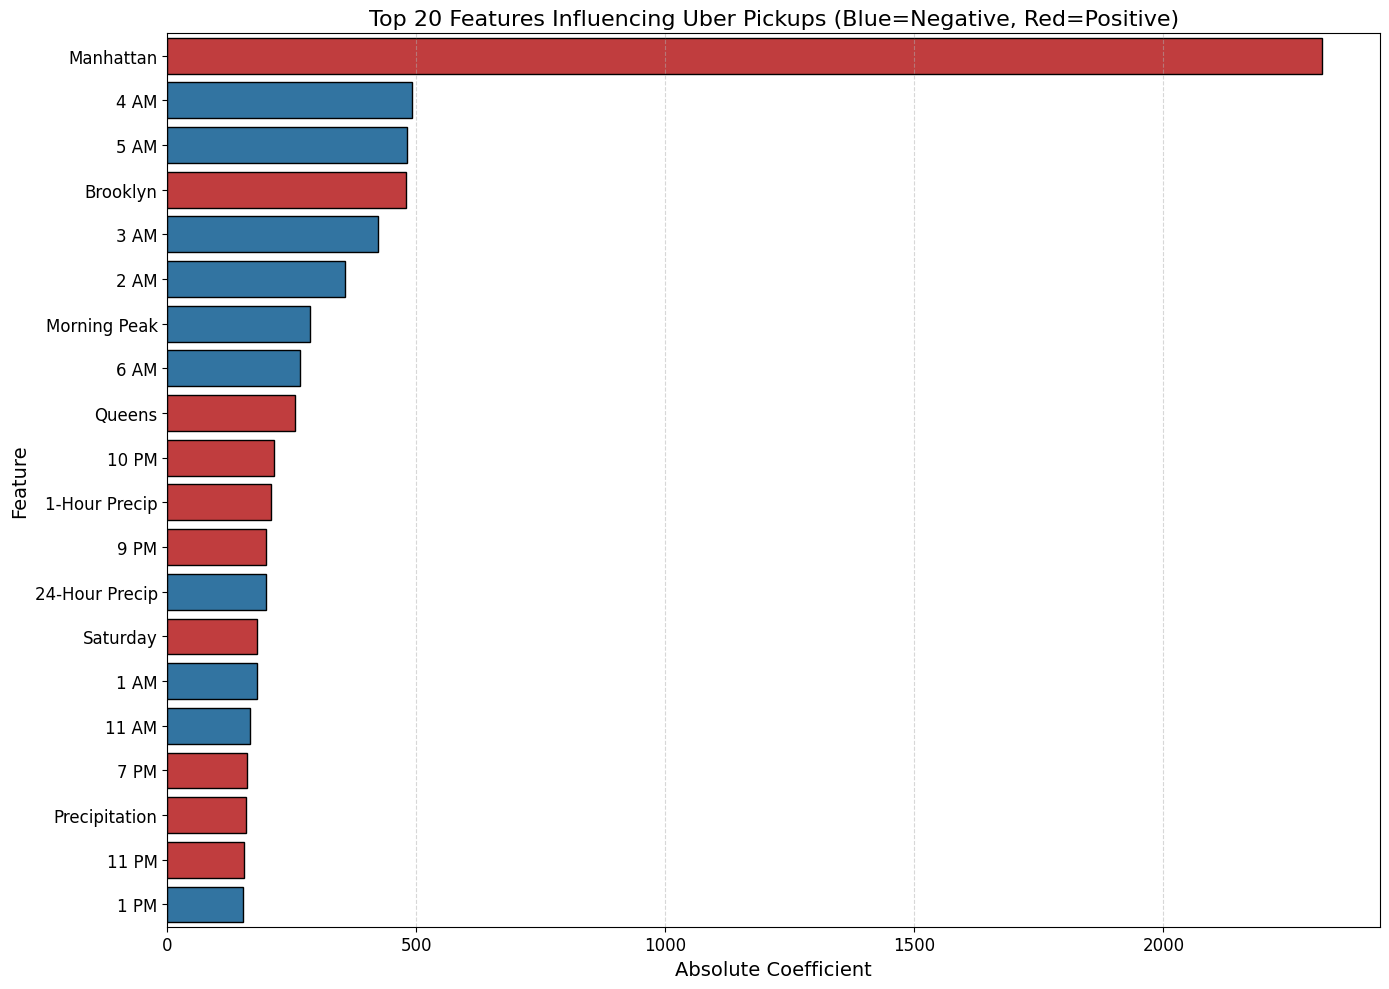

In [29]:
# 生成带正负标注和重命名的特征重要性图
import seaborn as sns
import matplotlib.pyplot as plt

# 前20特征，含原始系数
top_features = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_,
    'Absolute Coefficient': abs(model.coef_)
}).sort_values('Absolute Coefficient', ascending=False).head(20)

# 特征重命名映射（示例，按需扩展）
feature_mapping = {
    'borough_Manhattan': 'Manhattan',
    'hour_4': '4 AM',
    'hour_5': '5 AM',
    'borough_Brooklyn': 'Brooklyn',
    'hour_3': '3 AM',
    'hour_2': '2 AM',
    'time_of_day_morning_peak': 'Morning Peak',
    'hour_6': '6 AM',
    'borough_Queens': 'Queens',
    'hour_22': '10 PM',
    'pcp01': '1-Hour Precip',
    'hour_21': '9 PM',
    'pcp24': '24-Hour Precip',
    'day_6': 'Saturday',
    'hour_1': '1 AM',
    'hour_11': '11 AM',
    'hour_19': '7 PM',
    'precip': 'Precipitation',
    'hour_23': '11 PM',
    'hour_13': '1 PM'
}
top_features['Feature'] = top_features['Feature'].map(feature_mapping)

# 绘图
plt.figure(figsize=(14, 10))
sns.barplot(
    x='Absolute Coefficient',
    y='Feature',
    data=top_features,
    palette=['#1f77b4' if c < 0 else '#d62728' for c in top_features['Coefficient']],
    edgecolor='black'  # 添加边框，增强条形区分度
)
plt.title('Top 20 Features Influencing Uber Pickups (Blue=Negative, Red=Positive)', fontsize=16)
plt.xlabel('Absolute Coefficient', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)  # 添加水平网格
plt.tight_layout()
plt.show()

###**结论**

1.模型性能：测试集 R²=0.725，证明 “时间 - 天气 - 区域” 特征对订单波动有强解释力（远超目标 R²>0.5）
<p>
2.特征影响：

1)正影响：曼哈顿、布鲁克林等行政区人口密集，需求高;晚高峰时段（21-23 点)出行集中，雨天需求增加，系数为正。

2)负影响：凌晨时段（1-5点），需求低
<p>
3.可视化：小时订单趋势早低晚高、周末需求波动大、Manhattan、Brooklyn地区需求大。